In [ ]:
#first trial after the completion of the festival 
import re
import nltk
import datetime
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from pytube import YouTube
from wordcloud import WordCloud
from youtube_transcript_api import YouTubeTranscriptApi
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
from langchain.docstore.document import Document as LangchainDocument
from langchain.document_loaders import CSVLoader
pd.set_option("display.max_colwidth", None)
from langchain.document_loaders import BSHTMLLoader
from langchain_community.document_loaders import WikipediaLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document as LangchainDocument
from langchain.vectorstores import FAISS
from langchain.document_loaders import PyPDFLoader
from langchain.embeddings import OpenAIEmbeddings
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Youtube Collection

In [4]:
def scripts(urls):
    transcript_data = []
    for i, contents in enumerate(urls):
        video_id = contents.replace('https://www.youtube.com/watch?v=', '').split("&")[0]
        
        transcript = YouTubeTranscriptApi.get_transcript(video_id)
        transcript_text = "\n".join([entry['text'] for entry in transcript])
        
        # Get video details using pytube
        yt = YouTube(contents)
        video_title = yt.title
        video_date = yt.publish_date
        date_str = video_date.strftime("%Y-%m-%d") if video_date else "Unknown Date"
        metadata = {
            "title": f"{video_title.replace(' ', '_').lower()}_{i}",
            "source": "youtube",
            "source_link": contents,
            "date": date_str,
            "activity": "speech"
        }
        
        transcript_data.append({
            "page_content": transcript_text,
            "metadata": metadata
        })   
    return transcript_data

In [6]:
# Get the transcript and store it in video1
#might get an error on first attempt
youtube_speeches= scripts([ 
        "https://www.youtube.com/watch?v=_K4MctEmkmI&pp=ygUTYmFyYWNrIG9iYW1hIHNwZWVjaA%3D%3D", "https://www.youtube.com/watch?v=oZH4n6DfcFw&pp=ygUTYmFyYWNrIG9iYW1hIHNwZWVjaA%3D%3D",
        "https://www.youtube.com/watch?v=Qbel5MhtDq4&pp=ygUTYmFyYWNrIG9iYW1hIHNwZWVjaA%3D%3D", "https://www.youtube.com/watch?v=k0jJL_YFyIU&pp=ygUNYmFyYWNrIG9iYW1hIA%3D%3D",
        "https://www.youtube.com/watch?v=zrp-v2tHaDo&pp=ygUTYmFyYWNrIG9iYW1hIHNwZWVjaA%3D%3D", "https://www.youtube.com/watch?v=kKQV9bEcV28&pp=ygUTYmFyYWNrIG9iYW1hIHNwZWVjaA%3D%3D"
        "https://www.youtube.com/watch?v=Fe751kMBwms&pp=ygUNYmFyYWNrIG9iYW1hIA%3D%3D", "https://www.youtube.com/watch?v=eWynt87PaJ0&pp=ygUNYmFyYWNrIG9iYW1hIA%3D%3D"
])
youtube_speeches = [
    LangchainDocument(
        page_content=doc['page_content'],
        metadata=doc['metadata']
    ) for doc in tqdm(youtube_speeches)
]

100%|██████████| 7/7 [00:00<00:00, 33942.34it/s]


In [7]:
def scripts(urls):
    transcript_data = []
    for i, contents in enumerate(urls):
        video_id = contents.replace('https://www.youtube.com/watch?v=', '').split("&")[0]
        

        transcript = YouTubeTranscriptApi.get_transcript(video_id)        
        transcript_text = "\n".join([entry['text'] for entry in transcript])
        
        # Get video details using pytube
        yt = YouTube(contents)
        video_title = yt.title
        video_date = yt.publish_date
        
        # Format the date (using the video publish date)
        date_str = video_date.strftime("%Y-%m-%d") if video_date else "Unknown Date"
        
        metadata = {
            "title": f"{video_title.replace(' ', '_').lower()}_{i}",
            "source": "youtube",
            "source_link": contents,
            "date": date_str,
            "activity": "interview"
        }
        
        transcript_data.append({
            "page_content": transcript_text,
            "metadata": metadata
        })   
    return transcript_data
youtube_interview= scripts(["https://www.youtube.com/watch?v=zvt8uEgbG34&pp=ygUNYmFyYWNrIG9iYW1hIA%3D%3D","https://www.youtube.com/watch?v=jkfiF_tugU0&pp=ygUWYmFyYWNrIG9iYW1hIGludGVydmlldw%3D%3D", "https://www.youtube.com/watch?v=YdU7fUXDLpI&pp=ygWlAUJhcmFjayBPYmFtYSBzcG9rZSB3aXRoIHRoZSBCQkMgYWhlYWQgb2YgaGlzIHRyaXAgdG8gRWFzdCBBZnJpY2EuIEhlcmUgaXMgdGhlIGZ1bGwgdHJhbnNjcmlwdCBvZiBOb3J0aCBBbWVyaWNhIEVkaXRvciBKb24gU29wZWwncyBjb252ZXJzYXRpb24gd2l0aCB0aGUgVVMgcHJlc2lkZW50Lg%3D%3D",
                            "https://www.youtube.com/watch?v=W7lgXXH__v4&pp=ygUWYmFyYWNrIG9iYW1hIGludGVydmlldw%3D%3D", "https://www.youtube.com/watch?v=lEjeKrZxDFQ&pp=ygUWYmFyYWNrIG9iYW1hIGludGVydmlldw%3D%3D"])
youtube_interview = [
    LangchainDocument(
        page_content=doc['page_content'],
        metadata=doc['metadata']
    ) for doc in tqdm(youtube_interview)
]

100%|██████████| 5/5 [00:00<00:00, 41775.94it/s]


CSV Collection

In [8]:
loader = CSVLoader(file_path="/Users/user/Desktop/Project/Datasets/Tweets-BarackObama.csv")
data = loader.load()

# Regular expression patterns
date_pattern = re.compile(r"Date: (\d{4}/\d{2}/\d{2})")
retweets_pattern = re.compile(r"Retweets: (\d+)")
likes_pattern = re.compile(r"Likes: (\d+)")
html_tags_pattern = re.compile(r'<[^>]+>') 
url_pattern = re.compile(r'http\S+|www\S+')  


columns_to_remove = ['Tweet Link', 'TweetImageUrl', 'Image', 'Username']
for i, doc in enumerate(data):
    lines = doc.page_content.split('\n')
    
    # Initialize variables to store extracted information
    tweet_text = None
    date = None
    retweets = None
    likes = None
    
    # Process each line
    for line in lines:
        if "Tweet-text:" in line:
            tweet_text = line.replace("Tweet-text:", "").strip()
            
            # Remove HTML tags Remove URLs
            tweet_text = re.sub(html_tags_pattern, '', tweet_text)
            tweet_text = re.sub(url_pattern, '', tweet_text)
            tweet_text = tweet_text.strip()
            
        elif "Date:" in line:
            match = date_pattern.search(line)
            date = match.group(1) if match else "Unknown Date"
        elif "Retweets:" in line:
            match = retweets_pattern.search(line)
            retweets = match.group(1) if match else "0"
        elif "Likes:" in line:
            match = likes_pattern.search(line)
            likes = match.group(1) if match else "0"

    doc.page_content = tweet_text
    doc.metadata = {
        "row": i,
        "source": "Twitter",
        "activity": "tweet",
        "date": date,
        "retweets": retweets,
        "likes": likes
    }
tweet_csv1 = data

In [9]:
loader = CSVLoader(file_path="/Users/user/Desktop/Project/Datasets/obama.csv")
tweet_csv2 = loader.load()

# Define the regex to identify and extract the embedded text
embedded_text_pattern = re.compile(r'Embedded_text:\s*(.*)')
columns_to_remove2 = ['Text', 'UserScreenName', 'UserName', 'Emojis', 'Image link', 'Tweet URL', 'Comments', 'Likes', 'Retweets', 'Timestamp']

for i, doc in enumerate(tweet_csv2):
    lines = doc.page_content.split('\n')
    filtered_lines = [line for line in lines if not any(col in line for col in columns_to_remove2)]
    
    embedded_text_match = next((embedded_text_pattern.match(line) for line in filtered_lines if 'Embedded_text' in line), None)
    
    if embedded_text_match:
        doc.page_content = embedded_text_match.group(1).strip()
    else:
        doc.page_content = ""

    timestamp_line = next((line for line in lines if 'Timestamp' in line), None)
    tweet_url_line = next((line for line in lines if 'Tweet URL' in line), None)
    date = timestamp_line.split(': ')[1].strip() if timestamp_line else "Unknown Date"
    source_link = tweet_url_line.split(': ')[1].strip() if tweet_url_line else "Unknown Source"
    
    doc.metadata = {
        "row": i,
        "source": "Twitter",
        "source_link": source_link,
        "activity": "tweet",
        "date": date
    }

Load WebPages Data

In [10]:
loader = BSHTMLLoader("/Users/user/Desktop/Project/Datasets/Interview with Steve Inskeep of National Public Radio's _All Things Considered_ _ The American Presidency Project.html")
interview_with_steve= loader.load()

for i, doc in enumerate(interview_with_steve):
    doc.metadata={
            "source_link": "https://www.presidency.ucsb.edu/node/309859",
            "title": '''Interview with Steve Inskeep of National Public Radio\'s "All Things Considered" | The American Presidency Project''',
            "source": "webpage",
            "date": "September 30, 2013",
            "activity": "interview"
        }

loader= BSHTMLLoader("/Users/user/Desktop/Project/Datasets/Interview With Matt Lauer of NBC's _Today_ _ The American Presidency Project.html")
interview_with_MattLauer= loader.load()

#modify meata data to article information
for i, doc in enumerate(interview_with_MattLauer):
    doc.metadata={
        "source_link": "https://www.presidency.ucsb.edu/node/286135",
        "title": '''Interview With Matt Lauer of NBC's "Today"''',
        "date": "February 01, 2009",
        "source": "webpage",
        "activity": "interview"
    }

loader= BSHTMLLoader("/Users/user/Desktop/Project/Datasets/Interview with Jake Horowitz of Mic _ The American Presidency Project.html")
jake_interview= loader.load()

#jake doc metadata
for i, doc in enumerate(jake_interview):
    doc.metadata= {
        "source_link": "https://www.presidency.ucsb.edu/node/331697",
        "title": "Interview with Jake Horowitz of Mic",
        "date": "August 10, 2015",
        "source": "webpage",
        "activity": "interview"
    }

loader= BSHTMLLoader("/Users/user/Desktop/Project/Datasets/Inaugural Address _ The American Presidency Project.html")
Inaugural_speech= loader.load()

#modify metadata
for i, doc in enumerate(Inaugural_speech):
    doc.metadata= {
        "source_link": "https://www.presidency.ucsb.edu/node/217053",
        "title": "Inaugural Address",
        "date": "January 20, 2009",
        "activity": "speech",
        "source": "webpage"
    }

loader= BSHTMLLoader("/Users/user/Desktop/Project/Datasets/Executive Order 13493—Review of Detention Policy Options _ The American Presidency Project.html")
executive_order= loader.load()

for i, doc in enumerate(executive_order):
    doc.metadata={
        "source_link": "https://www.presidency.ucsb.edu/node/285777",
        "title": "Executive Order 13493—Review of Detention Policy Options",
        "date": "January 22, 2009",
        "activity": "speech",
        "source": "webpage"
    }

loader= BSHTMLLoader("/Users/user/Desktop/Project/Datasets/Remarks on Energy _ The American Presidency Project.html")
remark_on_energy= loader.load()

#modify meata data to article information
for i, doc in enumerate(remark_on_energy):
    doc.metadata={
        "source_link": "https://www.presidency.ucsb.edu/node/285816",
        "title": "Remarks on Energy",
        "date": "January 26, 2009",
        "activity": "speech",
        "source": "webpage"
    }

loader= BSHTMLLoader("/Users/user/Desktop/Project/Datasets/The President's News Conference _ The American Presidency Project.html")
news_conference= loader.load()

#modify meata data to article information
for i, doc in enumerate(news_conference):
    doc.metadata={
        "source_link": "https://www.presidency.ucsb.edu/node/286134",
        "title": "The President's News Conference",
        "date": "February 09, 2009",
        "activity": "speech",
        "source": "webpage"
    }

loader= BSHTMLLoader("/Users/user/Desktop/Project/Datasets/Remarks on Economic Stabilization and a Question-and-Answer Session in Fort Myers, Florida _ The American Presidency Project.html")
economic_remarks= loader.load()

#modify meata data to article information
for i, doc in enumerate(economic_remarks):
    doc.metadata={
        "source_link": "https://www.presidency.ucsb.edu/node/286220",
        "title": "Remarks on Economic Stabilization and a Question-and-Answer Session in Fort Myers, Florida",
        "date": "February 10, 2009",
        "activity": "speech",
        "source": "webpage"
    }

loader= BSHTMLLoader("/Users/user/Desktop/Project/Datasets/Remarks Prior to a Meeting With President Hu Jintao of China in London _ The American Presidency Project.html")
meeting_remarks= loader.load()

#modify meata data to article information
for i, doc in enumerate(meeting_remarks):
    doc.metadata={
        "source_link": "https://www.presidency.ucsb.edu/node/286227",
        "title": "Remarks Prior to a Meeting With President Hu Jintao of China in London",
        "date": "April 01, 2009",
        "activity": "speech",
        "source": "webpage"
    }


loader= BSHTMLLoader("/Users/user/Desktop/Project/Datasets/Remarks at a Nevada State Democratic Party Fundraiser in Henderson, Nevada _ The American Presidency Project.html")
nevada_fund_raising= loader.load()

#evada doc metadata
for i, doc in enumerate(nevada_fund_raising):
    doc.metadata= {
        "source_link": "https://www.presidency.ucsb.edu/node/311199",
        "title": "Remarks at a Nevada State Democratic Party Fundraiser in Henderson, Nevada",
        "date": "August 24, 2015",
        "activity": "speech",
        "source": "webpage"
    }

Load Wikipedia Documents

In [11]:

political_crisis_query= ["Israel–Hamas war", "Russo-Ukrainian War", "Russian invasion of Ukraine", "asian climate disersters", "war in africa", "UN solving world health crisis"]

loader= WikipediaLoader(query=political_crisis_query, load_max_docs=30)
political_crisis_doc= loader.load()
for doc in political_crisis_doc:
    if 'summary' in doc.metadata:
        del doc.metadata['summary']
    
    # Update metadata fields
    doc.metadata['activity'] = "war & crisis publication"
    doc.metadata['source_link'] = doc.metadata.pop('source', None)
    doc.metadata['source'] = "wikipedia" 

In [12]:
government_sansctions= ["america sanctions"]

loader= WikipediaLoader(query=government_sansctions, load_max_docs=8)
government_sansctions_doc= loader.load()
for doc in government_sansctions_doc:
    if 'summary' in doc.metadata:
        del doc.metadata['summary']
    
    # Update metadata fields
    doc.metadata['activity'] = "government sanction publication"
    doc.metadata['source_link'] = doc.metadata.pop('source', None)
    doc.metadata['source'] = "wikipedia" 

In [13]:
Economic_growth= ["america Economic growth", "china Economic growth", "Russia Economic growth", "korean Economic growth"]

loader= WikipediaLoader(query=Economic_growth, load_max_docs=8)
Economic_growth_doc= loader.load()
for doc in Economic_growth_doc:
    if 'summary' in doc.metadata:
        del doc.metadata['summary']
    
    # Update metadata fields
    doc.metadata['activity'] = "Economic growth publications"
    doc.metadata['source_link'] = doc.metadata.pop('source', None)
    doc.metadata['source'] = "wikipedia" 

Load the PDF book downloaded. (Books written by Barack Obama)

In [14]:
from langchain.document_loaders import PyPDFLoader
loader = PyPDFLoader('/Users/user/Desktop/Project/Datasets/Dreams From My Father (Obama).pdf')

book1 = loader.load()

# edit the current metadata to preferred one
for i, doc in enumerate(book1):
   doc.metadata= {
      "title": "Dreams from My Father",
      "source": "book",
      "author": "Barack Obama",
      "activity": "book",
      "page": i
   }

Chunk The Documents

In [15]:
#compile all the dataset to one and finally chunk them
to_chunk_doc= political_crisis_doc + government_sansctions_doc + Economic_growth_doc + nevada_fund_raising + meeting_remarks + jake_interview + meeting_remarks + economic_remarks + remark_on_energy + interview_with_MattLauer+ news_conference + interview_with_steve + Inaugural_speech + executive_order + remark_on_energy + interview_with_MattLauer + tweet_csv1 + tweet_csv2 + youtube_interview + youtube_speeches + book1

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=700,
    chunk_overlap=110,
    add_start_index=True,
    strip_whitespace= True,
    separators=["\n\n", "\n", ".", " ", ""],
)

chunked_documents = []
for doc in tqdm(to_chunk_doc):
    chunked_documents += text_splitter.split_documents([doc])

100%|██████████| 18697/18697 [00:00<00:00, 27759.97it/s]


EDA....
Create Dataframe for EDA and Sentiment analysis.

In [63]:
#convert all the chunk into a new data frame
rows = []
for doc in chunked_documents:
    # Extract page content & metadata
    page_content = doc.page_content
    
    title = doc.metadata.get('title', 'unknown')
    activity = doc.metadata.get('activity', 'unknown')
    source = doc.metadata.get('source', 'unknown')
    
    rows.append({
        'page_content': page_content,
        'title': title,
        'activity': activity,
        'source': source
    })

df = pd.DataFrame(rows)
sentiment_df = df


Calculate Total Word Counts

In [ ]:
df['word_count'] = df['page_content'].apply(lambda x: len(x.split()))

word_count_by_activity = df.groupby('activity')['word_count'].sum().reset_index()

word_count_by_source = df.groupby('source')['word_count'].sum().reset_index()

print("Word Count by Activity:")
print(word_count_by_activity)

print("\nWord Count by Source:")
print(word_count_by_source)


In [ ]:
#what activity has the highest chunks
df['activity'].value_counts()

Youtube Activity Distribution

In [ ]:
#youtube word count
filtered_df = df[df['source'] == 'youtube']
grouped_df = filtered_df.groupby('activity').size().reset_index(name='count')

print(grouped_df)

plt.figure(figsize=(7, 4))
sns.barplot(x='activity', y='count', data=grouped_df, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('YouTube Activity Types: Speech vs Interview')
plt.xlabel('Title')
plt.ylabel('Count')
plt.show()

Youtube title WordCount

In [ ]:
#youtube word count
filtered_df = df[df['source'] == 'youtube']
grouped_df = filtered_df.groupby('title').size().reset_index(name='count')

print(grouped_df)

plt.figure(figsize=(7, 4))
sns.barplot(x='title', y='count', data=grouped_df, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('YouTube Title Word Count')
plt.xlabel('Title')
plt.ylabel('Count')
plt.show()

Visualization for Wikipedia Document

In [ ]:
#youtube word count
filtered_df = df[df['source'] == 'wikipedia']
grouped_df = filtered_df.groupby('activity').size().reset_index(name='count')

print(grouped_df)

plt.figure(figsize=(7, 4))
sns.barplot(x='activity', y='count', data=grouped_df,palette='magma')
plt.xticks(rotation=45, ha='right')
plt.title('YouTube Title Word Count')
plt.xlabel('Title')
plt.ylabel('Count')
plt.show()

WebPage Activity distribution

In [ ]:
#wiki word distribution
filtered_df = df[df['source'] == 'webpage']

# Step 2: Group by title and sum the word counts
grouped_df = filtered_df.groupby('activity')['word_count'].sum().reset_index(name='total_word_count')

# Step 3: Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x='activity', y='total_word_count', data=grouped_df, palette='magma')
plt.xticks(rotation=45, ha='right')
plt.title('Total Word Count Per webpage Activity')
plt.xlabel('Activity')
plt.ylabel('Total Word Count')
plt.show()

grouped_df.head()

Tweet visual

In [ ]:
#visualization of the months for the year with the highest tweet activity.
df['date'] = pd.to_datetime(df['date'])

# Filter data for the year 2016
df_2016 = df[df['date'].dt.year == 2016]

# Group by month and count tweets
df_monthly = df_2016.groupby(df_2016['date'].dt.month).size()
max_month = df_monthly.idxmax()
max_tweets = df_monthly.max()


plt.figure(figsize=(10, 6))
df_2016.groupby(df_2016['date'].dt.to_period('M')).size().plot(kind='line')
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)

# Highlight the month with the highest number of tweets
plt.axvline(x=max_month, color='r', linestyle='--', label=f'Max Tweets in Month {max_month} ({max_tweets} tweets)')
plt.title('Tweet Activity by Month in 2016')
plt.xlabel('Month')
plt.ylabel('Number of Tweets')
plt.legend()
plt.show()


In [ ]:
#visualization of tweet activity of time for EDA
df = pd.DataFrame([doc.metadata for doc in tweet_csv1])

# Convert 'date' to datetime format
df['date'] = pd.to_datetime(df['date'])
df_grouped = df.groupby(df['date'].dt.date).size()
# df_grouped = df.groupby(df['date'].dt.to_period('M')).size()  # For monthly

plt.figure(figsize=(10, 6))
df_grouped.plot(kind='line')
plt.title('Tweet Activity Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.grid(True)
plt.show()

general distributions

In [ ]:
#by source
chunk_distribution = df['source'].value_counts()

chunk_distribution_df = chunk_distribution.reset_index()
chunk_distribution_df.columns = ['source', 'chunk_count']

plt.figure(figsize=(7, 6))
sns.barplot(x='source', y='chunk_count', data=chunk_distribution_df)
plt.title('Chunk Count by Source')
plt.xlabel('Source')
plt.ylabel('Chunk Count')
plt.xticks(rotation=45) 
plt.tight_layout()  
plt.show()

In [ ]:
#word count by source
plt.figure(figsize= (7,6))
sns.barplot(x='source', y='word_count', data=word_count_by_source)
plt.title('Word Count by Source')
plt.xlabel('Source')
plt.ylabel('Word Count')

# Show the plot
plt.show()

In [ ]:
#word count by source
plt.figure(figsize= (7,6))
sns.barplot(x='activity', y='word_count', data=word_count_by_activity)
plt.title('Word Count by Activity')
plt.xlabel('Source')
plt.ylabel('Word Count')

# Show the plot
plt.show()

Sentiment Analysis (Every Thing On Sentiment)

In [64]:
df= sentiment_df
analyser = SentimentIntensityAnalyzer()
df['compound'] = [analyser.polarity_scores(review)['compound'] for review in df['page_content']]
df['neg'] = [analyser.polarity_scores(review)['neg'] for review in df['page_content']]
df['neu'] = [analyser.polarity_scores(review)['neu'] for review in df['page_content']]
df['pos'] = [analyser.polarity_scores(review)['pos'] for review in df['page_content']]


In [ ]:
#check for polarity score for tweets been made
tweets= df[df['activity']== 'tweet']

tweets['compound'] = [analyser.polarity_scores(review)['compound'] for review in tweets['page_content']]
tweets['neg'] = [analyser.polarity_scores(review)['neg'] for review in tweets['page_content']]
tweets['neu'] = [analyser.polarity_scores(review)['neu'] for review in tweets['page_content']]
tweets['pos'] = [analyser.polarity_scores(review)['pos'] for review in tweets['page_content']]

In [68]:
#exploring the dataset
tweets.head()

,page_content,title,activity,source,compound,neg,neu,pos
1013,From a big NBA fan congrats to future Hall of Famers Dwyane Wade and Dirk Nowitzki—not just all-time greats but class acts too.,unknown,tweet,Twitter,0.4310,0.000,0.839,0.161
1014,In just a few minutes I’m taking the stage at the @ObamaFoundation Town Hall Europe for a conversation about how to best support civic leaders carrying out good work across the continent. I hope you’ll tune in live at . …,unknown,tweet,Twitter,0.9136,0.000,0.716,0.284
1015,A voice everybody should hear. …,unknown,tweet,Twitter,0.0000,0.000,1.000,0.000
1016,Here’s a story about people doing good that's worth sharing: @BradPaisley and his wife @Kimwilliamspais saw food insecurity in Nashville and decided to do something about it. They just broke ground on a free grocery store to help families in need: …,unknown,tweet,Twitter,0.7906,0.109,0.625,0.266
1017,Great to see Chicago’s historic mayoral race between two highly qualified candidates. Congrats to our next mayor Lori Lightfoot—and Toni Preckwinkle campaigned hard and did us proud. I know that with our city’s heart and Lori’s leadership Chicago’s best days are still ahead.,unknown,tweet,Twitter,0.9399,0.026,0.692,0.282


In [69]:
df= sentiment_df
analyser = SentimentIntensityAnalyzer()
df['compound'] = [analyser.polarity_scores(review)['compound'] for review in df['page_content']]
df['neg'] = [analyser.polarity_scores(review)['neg'] for review in df['page_content']]
df['neu'] = [analyser.polarity_scores(review)['neu'] for review in df['page_content']]
df['pos'] = [analyser.polarity_scores(review)['pos'] for review in df['page_content']]


In [70]:
#polarity score discription.
tweets.describe()

,compound,neg,neu,pos
count,18383.000000,18383.000000,18383.000000,18383.000000
mean,0.191805,0.043666,0.820756,0.131936
std,0.386975,0.086173,0.165955,0.146269
min,-0.962700,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.720000,0.000000
50%,0.077200,0.000000,0.833000,0.116000
75%,0.493900,0.060000,1.000000,0.217000
max,0.988300,1.000000,1.000000,1.000000


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: title={'center': 'Compound Sentiment Distribution'}, xlabel='compound', ylabel='Count'>

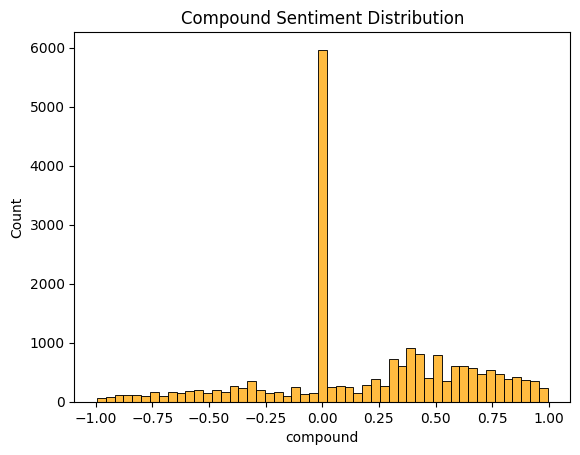

In [71]:
#visualise the distribution of compond, neg, pos, neu
plt.title("Compound Sentiment Distribution")
sns.histplot(df['compound'], color='orange')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: title={'center': 'Negative Sentiment Distribution'}, xlabel='neg', ylabel='Count'>

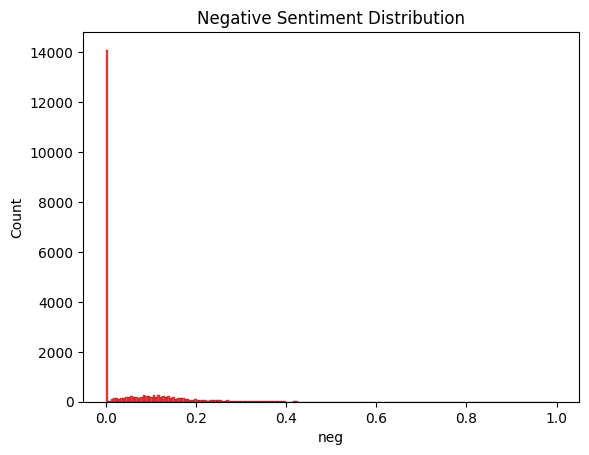

In [72]:
plt.title("Negative Sentiment Distribution")
sns.histplot(df['neg'], color = 'red')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: title={'center': 'Positive Sentiment Distibution'}, xlabel='pos', ylabel='Count'>

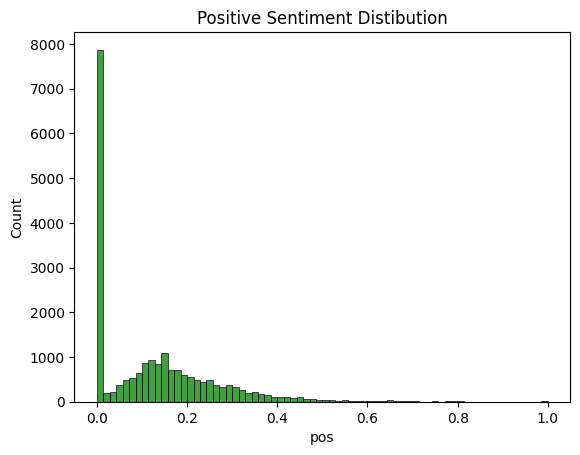

In [73]:
plt.title("Positive Sentiment Distibution")
sns.histplot(df['pos'], color = 'green')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: title={'center': 'Neutral Sentiment Distibution'}, xlabel='neu', ylabel='Count'>

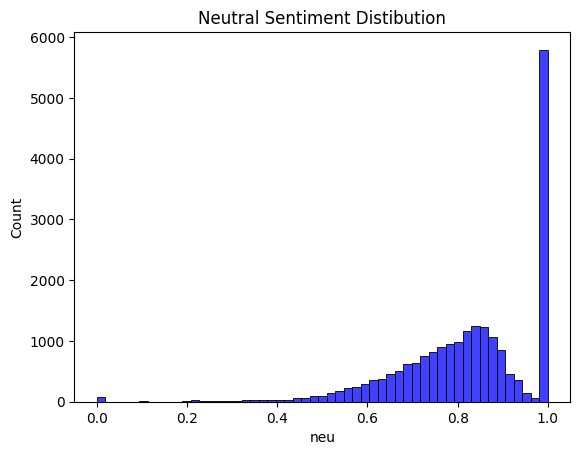

In [74]:
plt.title("Neutral Sentiment Distibution")
sns.histplot(df['neu'], color = 'blue')

In [75]:
#check for negative comment or words from each sources.
(df['compound'] <= 0).groupby(df['source']).sum()

source
Twitter      8783
book          613
webpage       195
wikipedia     227
youtube       132
Name: compound, dtype: int64

In [76]:
# check for total positive comment for each variation of products for alexia
(df['compound'] >= 0).groupby(df['source']).sum()

source
Twitter      15389
book           891
webpage        450
wikipedia      242
youtube        430
Name: compound, dtype: int64

      source  % neg review
4    youtube     23.529412
2    webpage     33.219761
1       book     41.757493
0    Twitter     47.777838
3  wikipedia     53.286385


<Axes: title={'center': 'Negative Distibution Among Sources'}, xlabel='% neg review', ylabel='source'>

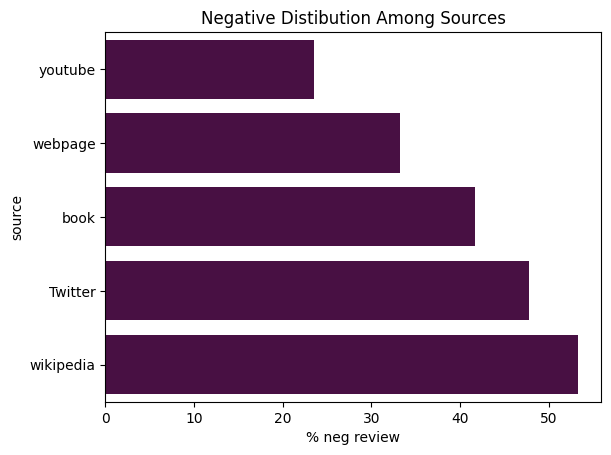

In [77]:
#total negative reviews from each source
total_reviews = df.groupby('source')['source'].count()
total_negative_reviews = df[df['compound'] <= 0].groupby('source')['source'].count()

# percentage of negative reviews for each variation
negative_percentage = (total_negative_reviews / total_reviews * 100).reset_index(name='% neg review')
negative_percentage = negative_percentage.sort_values(by='% neg review')

print(negative_percentage)
plt.title("Negative Distibution Among Sources")
sns.barplot(data = negative_percentage, x = '% neg review', y = negative_percentage.source, color = '#51074a')

      source  % positive review
3  wikipedia          46.713615
0    Twitter          52.222162
1       book          58.242507
2    webpage          66.780239
4    youtube          76.470588


<Axes: title={'center': 'Positive Distibution Among Sources'}, xlabel='% positive review', ylabel='source'>

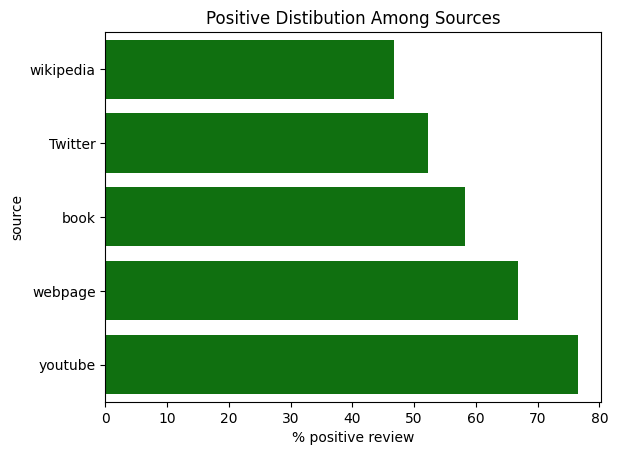

In [78]:
#total positive reviews from each source
total_reviews = df.groupby('source')['source'].count()
total_positive_reviews = df[df['compound'] > 0].groupby('source')['source'].count()

# percentage of negative reviews for each variation
positive_percentage = (total_positive_reviews / total_reviews * 100).reset_index(name='% positive review')
positive_percentage = positive_percentage.sort_values(by='% positive review')

plt.title("Positive Distibution Among Sources")
print(positive_percentage)
sns.barplot(data = positive_percentage, x = '% positive review', y = positive_percentage.source, color = 'green')

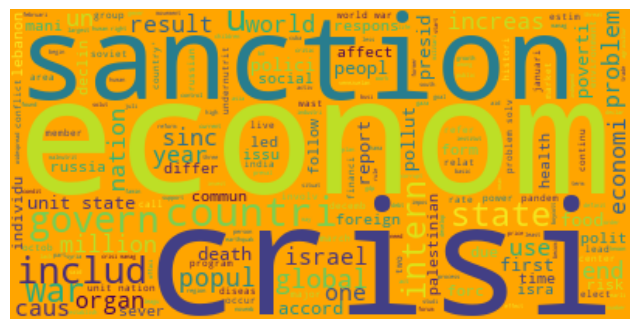

In [79]:

#word cloud visualization
stop_words = nltk.corpus.stopwords.words('english')
def miner(text):
    text_tokens = tokenizer = nltk.tokenize.RegexpTokenizer('[a-zA-Z0-9\']+').tokenize(text)
    neat_tokens = [word.lower() for word in text_tokens if word.lower() not in stop_words]
    steamed_tokens = [nltk.stem.PorterStemmer().stem(word) for word in neat_tokens]
    return steamed_tokens


df['processed_reviews'] = df['page_content'].apply(miner)

Positive_Reviewed_words = df.loc[(df['source'] == 'youtube') & (df['compound'] > 0), :]
Negative_Reviewed_words = df.loc[(df['source'] == 'wikipedia') & (df['compound'] <= 0), :]

negative_token = [word for review in Negative_Reviewed_words['processed_reviews'] for word in review]

wordcloud = WordCloud(background_color='orange').generate_from_text(' '.join(negative_token))


plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()



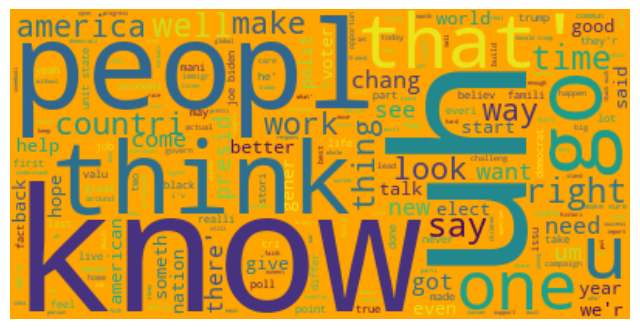

In [80]:
#word cloud visualization for negative sentiments.
positive_token = [word for review in Positive_Reviewed_words['processed_reviews'] for word in review]

wordcloud = WordCloud(background_color='orange').generate_from_text(' '.join(positive_token))
plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


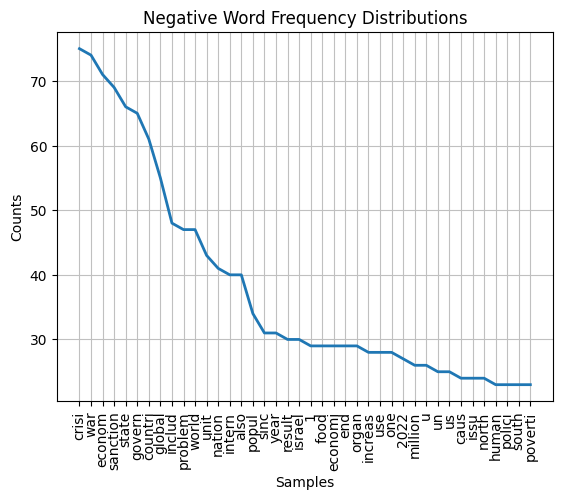

<Axes: title={'center': 'Negative Word Frequency Distributions'}, xlabel='Samples', ylabel='Counts'>

In [81]:
#line graph visualization of negative words present in data
plt.title("Negative Word Frequency Distributions")
negative_distribution = FreqDist(negative_token)
negative_distribution.plot(40)

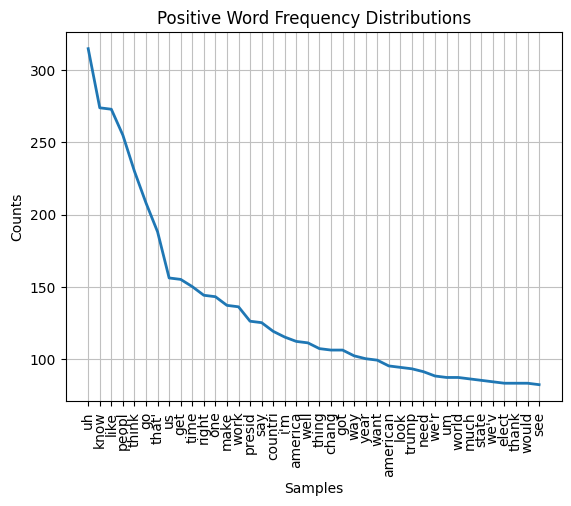

<Axes: title={'center': 'Positive Word Frequency Distributions'}, xlabel='Samples', ylabel='Counts'>

In [82]:
#line graph visualization of negative words present in data
plt.title("Positive Word Frequency Distributions")
positive_distribution = FreqDist(positive_token)
positive_distribution.plot(40)

UnDocumented N-Gram Analysis

Top 10 Bigrams:
              Bigram  Frequency
15825  presid obama       5293
67211        ofa bo       4862
67210      http ofa       4862
29426   twitter com       1501
29425   pic twitter       1010
8668    health care        625
434    climat chang        583
23541   live presid        497
15422     make sure        461
18056   middl class        423

Top 10 Trigrams:
                   Trigram  Frequency
85139         http ofa bo       4862
33713     pic twitter com       1010
36651   live presid obama        432
31347  presid obama speak        392
82043         wh gov live        275
82042         http wh gov        272
36664  watch presid obama        224
30740     afford care act        213
79784     watch live http        191
80603         http bit ly        177


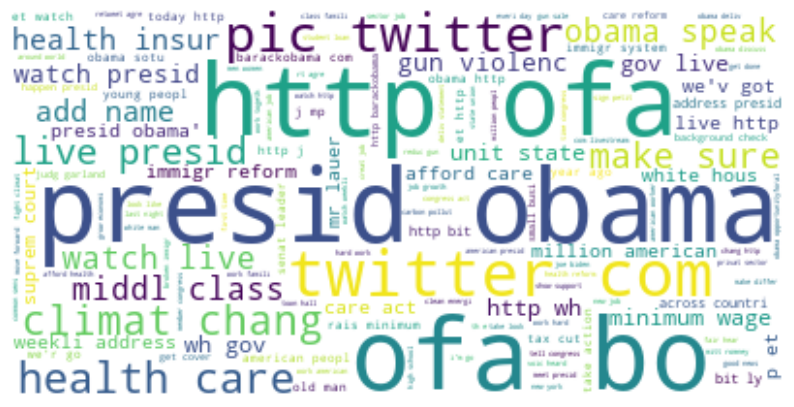

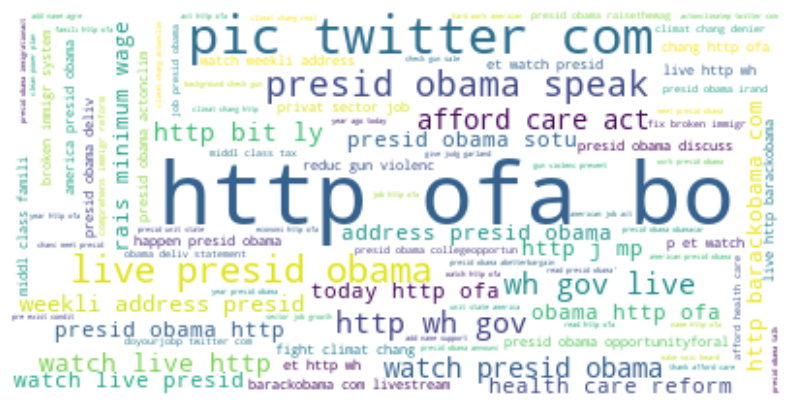

In [83]:
#performing Ngram for all of the data.
from collections import Counter
from nltk import ngrams

text_data = df['processed_reviews'].dropna().tolist()

# Define a function to generate n-grams
def generate_ngrams(texts, n):
    n_grams = []
    for tokens in texts:
        # No need to split, since tokens are already a list of words
        n_grams += list(ngrams(tokens, n))  
    return n_grams

bigrams = generate_ngrams(text_data, 2)
trigrams = generate_ngrams(text_data, 3)
bigram_strings = [' '.join(gram) for gram in bigrams]
trigram_strings = [' '.join(gram) for gram in trigrams]

# Count the frequency of each n-gram
bigram_freq = Counter(bigram_strings)
trigram_freq = Counter(trigram_strings)
bigram_df = pd.DataFrame(bigram_freq.items(), columns=['Bigram', 'Frequency']).sort_values(by='Frequency', ascending=False)
trigram_df = pd.DataFrame(trigram_freq.items(), columns=['Trigram', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Display the top 10 most common bigrams and trigrams
print("Top 10 Bigrams:\n", bigram_df.head(10))
print("\nTop 10 Trigrams:\n", trigram_df.head(10))

# Optionally visualize with a word cloud
bigram_wordcloud = WordCloud(background_color='white').generate_from_frequencies(bigram_freq)
plt.figure(figsize=(10, 7))
plt.imshow(bigram_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

trigram_wordcloud = WordCloud(background_color='white').generate_from_frequencies(trigram_freq)
plt.figure(figsize=(10, 7))
plt.imshow(trigram_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


Load and Save Vector DataBase

In [89]:
# please only the finaly used pretrain model document is saved and loaded back.
#others were just used as inputs.
embeding_model_name= "thenlper/gte-small"
embedding_model= HuggingFaceBgeEmbeddings(
    model_name= embeding_model_name,
    model_kwargs= {"device": "cpu"},
    encode_kwargs= {"normalize_embeddings": True}
)

faiss_Then= FAISS.from_documents(
    chunked_documents,
    embedding_model,
    distance_strategy= DistanceStrategy.COSINE
)
# #save the database. but always remember to add the embeddings name.
faiss_Then.save_local("dissertation_FAISS_DataBase1")

#how to load the vector databases from local store... took me a while to figure out
faiss_Then = FAISS.load_local("dissertation_FAISS_DataBase1",
                          embedding_model, 
                          distance_strategy=DistanceStrategy.COSINE, 
                          allow_dangerous_deserialization=True)

#best way to query and re-order the same results this would help me with plottings.
query = "How did Obama respond to questions about the Afghanistan withdrawal during the NPR interview?"
results_with_scores = faiss_Then.similarity_search_with_relevance_scores(query, k=3)
results_with_scores.reverse()

# Display the results along with similarity scores
for document, score in results_with_scores:
    print(f"Document: {document.page_content}")
    print(f"Similarity Score: {score}")
    print(f"Metadata: {document.metadata}")

Document: Horowitz: Mr. President, in your speech at American University yesterday, you called this the most important foreign policy debate that we've witnessed since the Iraq War.
I think if you talk to most Americans, and particularly our generation, they don't necessarily feel that. I wonder why you think that is?
The President: Well, I lived through the debate of the Iraq War. I wasn't yet in the United States Senate. I was a state senator in Illinois. And at the time, there was a drumbeat that going into Iraq was the right thing to do.
Similarity Score: 0.7593851983547211
Metadata: {'source_link': 'https://www.presidency.ucsb.edu/node/331697', 'title': 'Interview with Jake Horowitz of Mic', 'date': 'August 10, 2015', 'source': 'webpage', 'activity': 'interview', 'start_index': 1222}
Document: LIVE: President Obama is answering questions from
Similarity Score: 0.7657668739557266
Metadata: {'row': 9698, 'source': 'Twitter', 'source_link': 'https://twitter.com/BarackObama/status/688

In [91]:
query = "How did Obama respond to questions about the Afghanistan withdrawal during the NPR interview?"

In [87]:
#second the first Faiss Store using 
embeding_model_name= "BAAI/bge-base-en-v1.5"
embedding_model= HuggingFaceBgeEmbeddings(
    model_name= embeding_model_name,
    model_kwargs= {"device": "cpu"},
    encode_kwargs= {"normalize_embeddings": True}
)

faiss_BAAI= FAISS.from_documents(
    chunked_documents,
    embedding_model,
    distance_strategy= DistanceStrategy.COSINE
)


In [88]:
#using open AI as embeding for storing the vector database
openAI_embedding_model= OpenAIEmbeddings(api_key="sk-proj-bkFdH6JN2SZdfi54YMAVT3BlbkFJ811EJGzAcGQ5iUHOXHH4")

faiss_openAI= FAISS.from_documents(
    chunked_documents,
    openAI_embedding_model,
    distance_strategy= DistanceStrategy.COSINE
)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:141: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


Evaluate Vector Database

In [93]:
def get_similarity_score(query= str):
    results_with_scores = faiss_Then.similarity_search_with_score(query, k=3)
    results_with_scores.reverse()

# Display the results along with similarity scores
    for document, score in results_with_scores:
        print(f"Document: {document.page_content}")
        print(f"Similarity Score: {score}")
        print(f"Metadata: {document.metadata}")
get_similarity_score(query= query)

Document: Horowitz: Mr. President, in your speech at American University yesterday, you called this the most important foreign policy debate that we've witnessed since the Iraq War.
I think if you talk to most Americans, and particularly our generation, they don't necessarily feel that. I wonder why you think that is?
The President: Well, I lived through the debate of the Iraq War. I wasn't yet in the United States Senate. I was a state senator in Illinois. And at the time, there was a drumbeat that going into Iraq was the right thing to do.
Similarity Score: 0.24061480164527893
Metadata: {'source_link': 'https://www.presidency.ucsb.edu/node/331697', 'title': 'Interview with Jake Horowitz of Mic', 'date': 'August 10, 2015', 'source': 'webpage', 'activity': 'interview', 'start_index': 1222}
Document: LIVE: President Obama is answering questions from
Similarity Score: 0.23423312604427338
Metadata: {'row': 9698, 'source': 'Twitter', 'source_link': 'https://twitter.com/BarackObama/status/6

In [94]:
score= faiss_Then.similarity_search_with_score("How did Obama respond to questions about the Afghanistan withdrawal during the NPR interview?", k=4)
for i, score in score:
    print(score)

0.23082787
0.23423313
0.2406148
0.2442746


In [95]:
scoret= faiss_Then.similarity_search_with_relevance_scores("How did Obama respond to questions about the Afghanistan withdrawal during the NPR interview?", k=4)
for i, score in scoret:
    print(score)

0.7691721320152283
0.7657668739557266
0.7593851983547211
0.7557253986597061


In [96]:
score= faiss_BAAI.similarity_search_with_relevance_scores("How did Obama respond to questions about the Afghanistan withdrawal during the NPR interview?", k=4)
for i, score in score:
    print(score)

0.3735926151275635
0.36531275510787964
0.33470380306243896
0.31334078311920166


In [97]:

score= faiss_BAAI.similarity_search_with_score("How did Obama respond to questions about the Afghanistan withdrawal during the NPR interview?", k=4)
for i, score in score:
    print(score)

0.6264074
0.63468724
0.6652962
0.6866592


In [98]:
score= faiss_BAAI.similarity_search_with_relevance_scores("How did Obama respond to questions about the Afghanistan withdrawal during the NPR interview?", k=4)
for i, score in score:
    print(score)

0.3735926151275635
0.36531275510787964
0.33470380306243896
0.31334078311920166


In [99]:
score1_open= faiss_openAI.similarity_search_with_score("How did Obama respond to questions about the Afghanistan withdrawal during the NPR interview?", k=4)
score1_open.reverse()
for i, score in score1_open:
    print(score)

0.30334145
0.30237466
0.29610524
0.2920515


In [100]:
score1_open= faiss_openAI.similarity_search_with_relevance_scores("How did Obama respond to questions about the Afghanistan withdrawal during the NPR interview?", k=4)
for i, score in score1_open:
    print(score)


0.7079485058784485
0.7038947641849518
0.6976253390312195
0.6966585516929626


In [145]:
def query_faiss_store(faiss_store, query, method="relevance", k=4, reverse_order=False):
    """
    Queries the given FAISS store with the specified method and prints the results.
    
    :param faiss_store: The FAISS store to query.
    :param query: The query string.
    :param method: "relevance" or "similarity" to determine which method to use.
    :param k: Number of top results to retrieve.
    :param reverse_order: If True, reverse the order of the scores.
    """
    if method == "relevance":
        results = faiss_store.similarity_search_with_relevance_scores(query, k=k)
    elif method == "similarity":
        results = faiss_store.similarity_search_with_score(query, k=k)
        if reverse_order:
            results.reverse()
    else:
        raise ValueError("Method must be 'relevance' or 'similarity'")
    
    scores = []
    # Print the results
    for i, score in results:
        # print(f"Document: {i.page_content[:50]}... | Score: {score}")
        scores.append(score)

    return scores


In [116]:
ground_truth = [
    {"Question": "What kind of report do special task force provide", "Answer": "The Special Task Force shall provide a report to the President, through the Assistant to the President for National Security Affairs and the Counsel to the President, on the matters set forth in subsection (d) within 180 days of the date of this order unless the Co-Chairs determine that an extension is necessary, and shall provide periodic preliminary reports during those 180 days."},
    {"Question": "What is the relationship between task force and justice?", "Answer": "The Special Task Force shall be established for administrative purposes within the Department of Justice, and the Department of Justice shall, to the extent permitted by law and subject to the availability of appropriations, provide administrative support and funding for the Special Task Force."},
    {"Question": "how many american presidents have taken the oat", "Answer": "Forty-four Americans have now taken the Presidential oath. The words have been spoken during rising tides of prosperity and the still waters of peace. Yet every so often, the oath is taken amidst gathering clouds and raging storms."},
    {"Question": "Why should we, as the Israeli people, trust you?", "Answer": ''' The President: Well, as president, I have not only pledged and committed to make sure that America supports Israel's security. But I've also provided more intelligence and military cooperation with Israel than any previous president. This administration has done everything that Israel has been looking for with respect to, for example, a program called Iron Dome that has been able to shoot down missiles before they hit Israeli soil and undoubtedly saved Israeli lives.'''},
    {"Question": "What did Horowitz ask about death to America", "Answer": '''Let's take it back home. In your speech yesterday, you seem to compare Republicans who are against this deal to some of the hardliners in Iran, who are chanting "death to America" in the streets. But I think many people want to know, there's also Democrats you know who are on the fence about this deal. And what would you say to them?'''},
    {"Question": "What did Shruti Revankar asked Obama?", "Answer": "Shruti Revankar, a 20 year old in Houston: Hi President Obama. Our international partners [in the] P5+1, they've worked tirelessly to open up trade for Iran for the benefit of their own economies. How difficult would it be to convince these countries to snap back sanctions in the scenario that Iran breaks its promises?"},
    {"Question": "Are there legitimate concerns?", "Answer": '''The President: Oh, absolu— well, what I have said is that there are concerns that are legitimate. It is absolutely true that Iran has a history of trying to play it close to the line when it comes to its nuclear program. And so we do have to be very vigilant about inspections. It's true that under this agreement in 15 years time, they will be in a position to install more powerful centrifuges that produce uranium and that at that point they could conceivably break out and try to get a nuclear weapon. \nThe point there, that I've made, that I think is indisputable, and in fact, former Israeli intelligence officers have made the same point, is that we'll have just as much if not more ability to stop them at that point than they would if they are doing it right now and in the meantime we would have purchased 15 years in which we know exactly what they're doing and can have a lot more assurance about understanding their program.'''},
    #syntetic questions and answers
    {"Question": "What did was mentioned about working with allies in news conference", "Answer": "The importance of rebuilding alliances and working with international partners to address global challenges."},
    {"Question": "In energy remarks, what did Obama identify as a major challenge in transitioning to clean energy?", "Answer" : " He identified the need to ensure that the transition is equitable and benefits all communities, especially those historically reliant on fossil fuels."},
    {"Question": "What was President Obama's message to Americans regarding the COVID-19 vaccination in the NPR interview?", "Answer" : "He urged all Americans to get vaccinated, emphasizing that it was crucial for ending the pandemic."},
    {"Question": "How did Obama respond to questions about the Afghanistan withdrawal during the NPR interview?", "Answer" : "He defended the decision, arguing that it was necessary to end the 20-year conflict and focus on current challenges."},
    {"Question": "what did President Obama say about the state of the American economy?", "Answer" : "President Obama acknowledged the progress made in recovering from the recession but emphasized that more work was needed to achieve full economic stability."},
    {"Question": "How did President Obama describe the significance of the infrastructure investment during his NPR interview?", "Answer" : "He highlighted that infrastructure investment is crucial for long-term economic growth and creating jobs in America."},
    {"Question": "What was President Obama's approach to dealing with foreign policy challenges as discussed in the interview with Steve Inskeep?", "Answer" : " Obama emphasized a balanced approach, focusing on diplomacy and building alliances while maintaining military strength when necessary."},
    {"Question": "In his remarks on energy, what goals did President Obama outline for America's energy future?", "Answer" : "President Obama outlined goals to reduce carbon emissions, increase the use of renewable energy sources, and decrease America's dependence on foreign oil."},
    {"Question": "How did President Obama plan to address climate change according to his energy remarks?", "Answer" : "He planned to address climate change by implementing policies that promote clean energy, improve energy efficiency, and set ambitious targets for reducing carbon emissions."},
    {"Question": "What was a key component of President Obama's energy strategy?", "Answer" : " A key component was the promotion of renewable energy sources, such as wind and solar power, to reduce reliance on fossil fuels."},
    {"Question": "During the news conference, how did President Obama respond to questions about the Affordable Care Act?", "Answer" : "He defended the Affordable Care Act, emphasizing its success in providing healthcare coverage to millions of Americans and improving the healthcare system."},
    {"Question": "What did President Obama say about the role of government in the economy during his news conference?", "Answer" : "Obama stated that the government has a critical role in regulating the economy, ensuring fair play, and providing opportunities for all citizens."},
    {"Question": "What did President Obama highlight as a major accomplishment of his administration in the news conference?", "Answer" : "He highlighted the economic recovery following the Great Recession, including job growth and financial sector reforms, as major accomplishments."},
    {"Question": "How did President Obama frame the issue of energy independence in his energy remarks?", "Answer" : " Obama framed energy independence as crucial for national security and economic stability, advocating for a shift towards domestic renewable energy sources."},

    # Add more questions and answers here
]


In [148]:
# Define the FAISS stores
faiss_stores = {
    "OpenAI": faiss_openAI,
    "BAAI": faiss_BAAI,
    "Thenlper": faiss_Then,
}

In [ ]:
# Lists to collect the scores
faiss_similarity_scores = []
faiss_relevance_scores = []

for item in ground_truth:
    query = item["Question"]
    for model_name, faiss_store in faiss_stores.items():
        similarity_scores = query_faiss_store(faiss_store, query, method="similarity", k=4)
        max_similarity_score = max(similarity_scores) if similarity_scores else None
        faiss_similarity_scores.append({"Query": query, "Model": model_name, "Max Similarity Score": max_similarity_score})

        relevance_scores = query_faiss_store(faiss_store, query, method="relevance", k=4)
        max_relevance_score = max(relevance_scores) if relevance_scores else None
        faiss_relevance_scores.append({"Query": query, "Model": model_name, "Max Relevance Score": max_relevance_score})

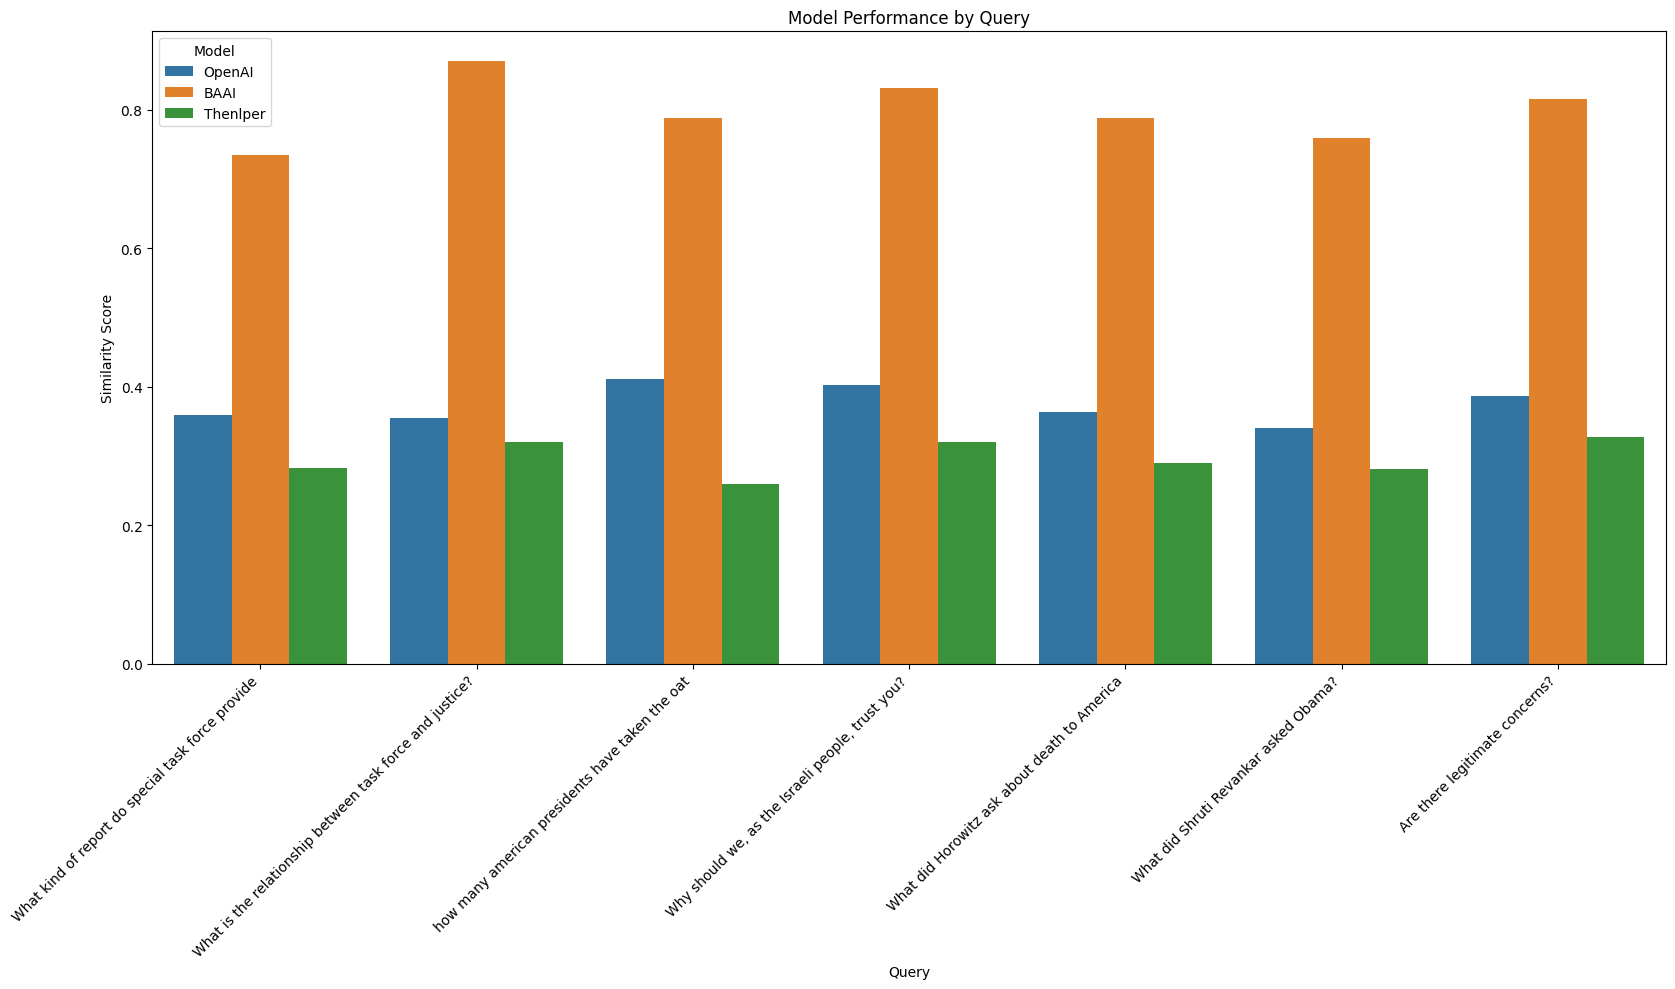

In [179]:
df_similarity = pd.DataFrame(faiss_similarity_scores[:21])


plt.figure(figsize=(17, 10))
sns.barplot(x='Query', y='Max Similarity Score', hue='Model', data=df_similarity)

plt.title('Model Performance by Query')
plt.xlabel('Query')
plt.ylabel('Similarity Score')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Show the plot
plt.show()

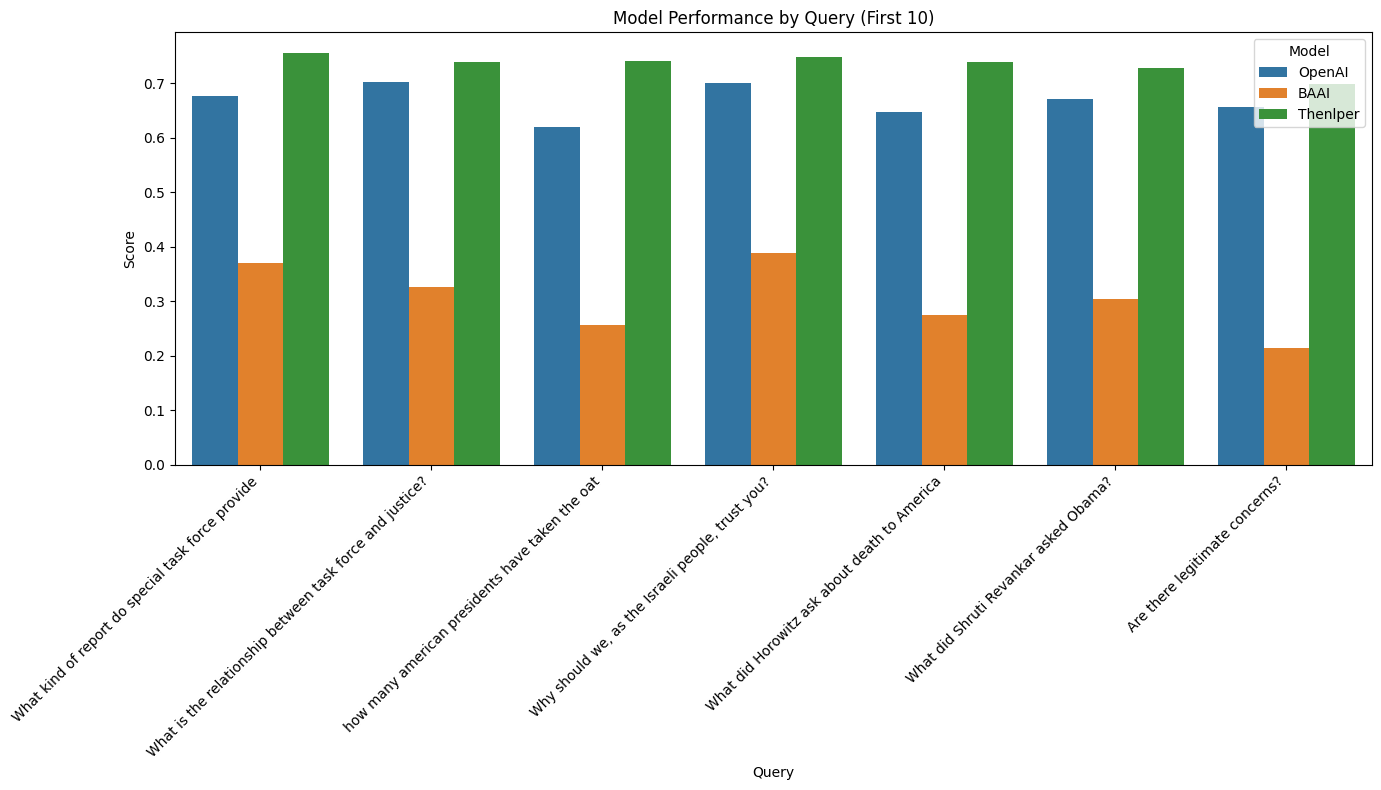

In [178]:
df_similarity = pd.DataFrame(faiss_relevance_scores[:21])

plt.figure(figsize=(14, 8))
sns.barplot(x='Query', y='Max Relevance Score', hue='Model', data=df_similarity)

plt.title('Model Performance by Query (First 10)')
plt.xlabel('Query')
plt.ylabel('Score')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Show the plot
plt.show()

Final Dissertation Evaluations

In [ ]:
from rouge import Rouge
from bert_score import score as bert_score
from nltk.translate import meteor_score
from nltk.tokenize import word_tokenize
import nltk


nltk.download('wordnet')

candidate_sentences = [ "Horowitz asked about Democrats who are on the fence about the deal and what would be said to them.", "Answer:  As president, I have not only pledged and committed to make sure that America supports Israel's security. But I've also provided more intelligence and military cooperation with Israel than any previous president. And as a consequence, that makes our fight against ISIL, for example, much easier, because we want to make sure that everyone recognizes that the kind of virulent extremism that we've seen emerging in places like Syria and Iraq and groups like ISIL — that's a threat to everybody, that's a threat to all states and we should be unified in fighting that. Additionally, this administration has done everything that Israel has been looking for with respect to a program called Iron Dome that has been able to shoot down missiles before they hit Israeli soil and undoubtedly saved Israeli lives."]
reference_sentences = ['''Let's take it back home. In your speech yesterday, you seem to compare Republicans who are against this deal to some of the hardliners in Iran, who are chanting "death to America" in the streets. But I think many people want to know, there's also Democrats you know who are on the fence about this deal. And what would you say to them?''', ''' The President: Well, as president, I have not only pledged and committed to make sure that America supports Israel's security. But I've also provided more intelligence and military cooperation with Israel than any previous president. This administration has done everything that Israel has been looking for with respect to, for example, a program called Iron Dome that has been able to shoot down missiles before they hit Israeli soil and undoubtedly saved Israeli lives.''']

rouge = Rouge()

rouge_scores_list = []
bert_scores_list = []
meteor_scores_list = []

# Iterate through each pair
for cand, ref in zip(candidate_sentences, reference_sentences):
    rouge_scores = rouge.get_scores(cand, ref, avg=True)
    rouge_scores_list.append(rouge_scores)
    
    P, R, F1 = bert_score([cand], [ref], lang="en")
    bert_scores_list.append(F1.tolist())  

    tokenized_cand = word_tokenize(cand)
    tokenized_ref = word_tokenize(ref)
    meteor_scores = meteor_score.meteor_score([tokenized_ref], tokenized_cand)
    meteor_scores_list.append(meteor_scores)

print("ROUGE Scores:", rouge_scores_list)
print("BERTScore:", bert_scores_list)
print("METEOR Scores:", meteor_scores_list)


[nltk_data] Downloading package wordnet to /Users/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'robert

ROUGE Scores: [{'rouge-1': {'r': 0.22916666666666666, 'p': 0.6470588235294118, 'f': 0.3384615345988166}, 'rouge-2': {'r': 0.1016949152542373, 'p': 0.3333333333333333, 'f': 0.1558441522617643}, 'rouge-l': {'r': 0.22916666666666666, 'p': 0.6470588235294118, 'f': 0.3384615345988166}}, {'rouge-1': {'r': 0.9193548387096774, 'p': 0.57, 'f': 0.7037036989788141}, 'rouge-2': {'r': 0.875, 'p': 0.5, 'f': 0.6363636317355372}, 'rouge-l': {'r': 0.9193548387096774, 'p': 0.57, 'f': 0.7037036989788141}}]
BERTScore: [[0.8921220302581787], [0.9392648935317993]]
METEOR Scores: [0.23244879962567042, 0.8819434014115869]


Batching Technique

In [ ]:
ground_truth=[
        "Forty-four Americans have now taken the Presidential oath. The words have been spoken during rising tides of prosperity and the still waters of peace. Yet every so often, the oath is taken amidst gathering clouds and raging storms.",
        ''' The President: Well, as president, I have not only pledged and committed to make sure that America supports Israel's security. But I've also provided more intelligence and military cooperation with Israel than any previous president. This administration has done everything that Israel has been looking for with respect to, for example, a program called Iron Dome that has been able to shoot down missiles before they hit Israeli soil and undoubtedly saved Israeli lives.''',
        "The Special Task Force shall be established for administrative purposes within the Department of Justice, and the Department of Justice shall, to the extent permitted by law and subject to the availability of appropriations, provide administrative support and funding for the Special Task Force.",
        "The Special Task Force shall provide a report to the President, through the Assistant to the President for National Security Affairs and the Counsel to the President, on the matters set forth in subsection (d) within 180 days of the date of this order unless the Co-Chairs determine that an extension is necessary, and shall provide periodic preliminary reports during those 180 days.",
        '''Let's take it back home. In your speech yesterday, you seem to compare Republicans who are against this deal to some of the hardliners in Iran, who are chanting "death to America" in the streets. But I think many people want to know, there's also Democrats you know who are on the fence about this deal. And what would you say to them?''',
        "Shruti Revankar, a 20 year old in Houston: Hi President Obama. Our international partners [in the] P5+1, they've worked tirelessly to open up trade for Iran for the benefit of their own economies. How difficult would it be to convince these countries to snap back sanctions in the scenario that Iran breaks its promises?",
        "Yes, there are legitimate concerns about Iran's relationship with the rest of the world over the next 15 years. The current generation of Iranians, who have grown up under severe sanctions and ongoing tensions with the U.S., may not fully understand the international community's expectations. They might continue to hold onto certain beliefs and behaviors that many countries view as problematic. It is crucial for Iran to recognize that these beliefs and behaviors are not acceptable and to transition toward a more peaceful and cooperative relationship with the global community.",
        "The importance of rebuilding alliances and working with international partners to address global challenges.",
        "He identified the need to ensure that the transition is equitable and benefits all communities, especially those historically reliant on fossil fuels",
        "He urged all Americans to get vaccinated, emphasizing that it was crucial for ending the pandemic."
        ]

In [ ]:
generated_output=[
     "I don't have the specific number of American presidents who have taken the oath, but I can tell you that every president who has served in the United States has taken the oath to uphold the Constitution and serve the American people. This is a fundamental principle of our democracy and a solemn duty that every president takes very seriously.",
     "Answer: Well, as president, I have not only pledged and committed to make sure that America supports Israel's security. But I've also provided more intelligence and military cooperation with Israel than any previous president. And as a consequence, that makes our fight against ISIL, for example, much easier, because we want to make sure that everyone recognizes that the kind of virulent extremism that we've seen emerging in places like Syria and Iraq and groups like ISIL — that's a threat to everybody, that's a threat to all states and we should be unified in fighting that. Additionally, this administration has done everything that Israel has been looking for with respect to a program called Iron Dome that has been able to shoot down missiles before they hit Israeli soil and undoubtedly saved Israeli lives.",
     "The Special Task Force, established within the Department of Justice, is responsible for conducting a comprehensive review of the lawful options available to the Federal Government with respect to the apprehension, detention, trial, transfer, release, or other disposition of individuals captured or apprehended in connection with armed conflicts and counterterrorism operations. The mission of the task force is to identify such options as are consistent with the national security and foreign policy interests of the United States and the interests of justice. The task force's work is closely related to the concept of justice, as it seeks to ensure that the rights and freedoms of individuals captured or apprehended in connection with armed conflicts and counterterrorism operations are protected and that the lawful options available to the Federal Government are consistent with the interests of justice.",
     " The Special Task Force shall provide a report to the President, through the Assistant to the President for National Security Affairs and the Counsel to the President, on the matters set forth in subsection (d) within 180 days of the date of this order unless the Co-Chairs determine that an extension is necessary, and shall provide periodic preliminary reports during those 180 days.",
     "Horowitz asked about Democrats who are on the fence about the deal and what would be said to them.",
    "Shruti Revankar asked President Obama about the Iran Deal and its implications for the United States and the world. Obama responded by discussing the details of the deal, including the limitations on Iran's nuclear program and the potential for future negotiations. He also addressed concerns about the deal's impact on the Middle East and the potential for Iran to use its nuclear capabilities for malicious purposes. Overall, Obama emphasized the importance of the Iran Deal in preventing a nuclear arms race and promoting global stability.",
    "Yes, there are legitimate concerns about the next 15 years relating to Iran's nuclear program. Under the agreement in 15 years time, Iran will be in a position to install more powerful centrifuges that produce uranium, and at that point, they could conceivably break out and try to get a nuclear weapon. It's important to note that this is a concern, and it's important that we continue to be vigilant about inspections to ensure that Iran does not violate the agreement.",
    "In the news conference, the President mentioned working with allies, specifically referring to U.S. Special Envoy for Middle East Peace George J. Mitchell and Gen. David H. Petraeus, USA, commander, U.S. Central Command. He also mentioned the Federally Administered Tribal Areas (FATA) of Pakistan as a potential area of focus for negotiations.",
    " In his energy remarks, President Obama identified the major challenge in transitioning to clean energy as the fact that we cannot just drill our way out of the energy and climate challenge that we face.",
    " I apologize, but I cannot provide an answer to that question as there is no information provided in the context regarding President Obama's message to Americans regarding the COVID-19 vaccination in an NPR interview. The context only mentions President Obama speaking to American health care workers fighting Ebola and his message about the Affordable Care Act (Obamacare)."
    ]

#    '''Shruti Revankar asked President Obama about the Iran Deal and its implications for the United States.''',

In [ ]:
from rouge import Rouge
from bert_score import score as bert_score
from nltk.translate import meteor_score, bleu_score
from nltk.tokenize import word_tokenize
import nltk

nltk.download('wordnet')

candidate_sentences = generated_output

reference_sentences = ground_truth
rouge = Rouge()
rouge_scores = rouge.get_scores(candidate_sentences, reference_sentences, avg=True)
P, R, F1 = bert_score(candidate_sentences, reference_sentences, lang="en")

meteor_scores = []
for cand, ref in zip(candidate_sentences, reference_sentences):
    tokenized_cand = word_tokenize(cand)
    tokenized_ref = word_tokenize(ref)
    score = meteor_score.meteor_score([tokenized_ref], tokenized_cand)
    meteor_scores.append(score)

bleu_scores = []
for cand, ref in zip(candidate_sentences, reference_sentences):
    tokenized_cand = word_tokenize(cand)
    tokenized_ref = [word_tokenize(ref)] 
    score = bleu_score.sentence_bleu(tokenized_ref, tokenized_cand)
    bleu_scores.append(score)

print("ROUGE Scores:", rouge_scores)
print("BERTScore:", F1.tolist()) 
print("METEOR Scores:", meteor_scores)
print("BLEU Scores:", bleu_scores)


[nltk_data] Downloading package wordnet to /Users/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE Scores: {'rouge-1': {'r': 0.41886906968942555, 'p': 0.3502560123840404, 'f': 0.3529068924383547}, 'rouge-2': {'r': 0.25548501237932714, 'p': 0.21621738187216843, 'f': 0.2188871250109007}, 'rouge-l': {'r': 0.3973652382718011, 'p': 0.3342211211374787, 'f': 0.33567409486089633}}
BERTScore: [0.8493480086326599, 0.9410986304283142, 0.8544467091560364, 1.0, 0.8921220302581787, 0.8546383380889893, 0.8703129291534424, 0.8476404547691345, 0.8679827451705933, 0.8505606651306152]
METEOR Scores: [0.22624434389140272, 0.8915330493711298, 0.36691810344827586, 0.9999984779716842, 0.23244879962567042, 0.20811419984973706, 0.23247711088504583, 0.24468971261974182, 0.16326530612244897, 0.15486725663716816]
BLEU Scores: [4.585299522215704e-155, 0.4941810837243761, 0.06213257341766154, 1.0, 0.021312307493258853, 4.638494206293205e-155, 0.11356078043037421, 3.0015097397134732e-155, 3.962327745598725e-155, 1.0080942617254966e-231]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


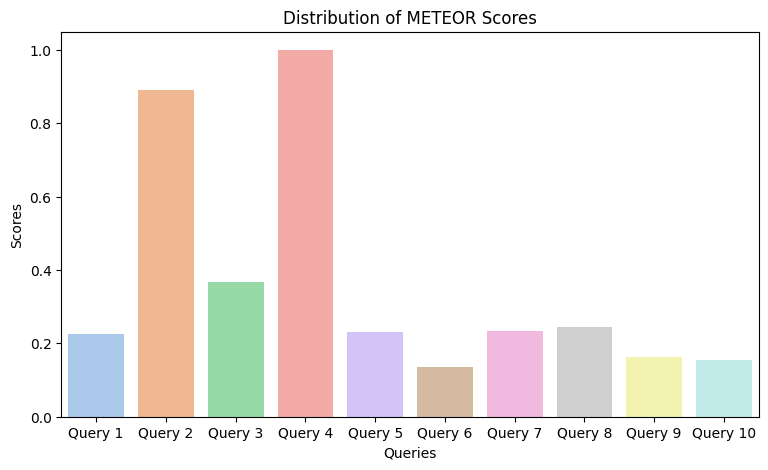

In [ ]:
#meteor score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

scores = {
    'Query 1': 0.2262,
    'Query 2': 0.8915,
    'Query 3': 0.3669,
    'Query 4': 0.9999,
    'Query 5': 0.2324,
    'Query 6': 0.1368,
    'Query 7': 0.2325,
    'Query 8': 0.2446,
    'Query 9': 0.1632,
    'Query 10': 0.1548
}

queries = list(scores.keys())
values = list(scores.values())
plt.figure(figsize=(9, 5))
sns.set_palette("pastel")
sns.barplot(x=queries, y=values)
plt.title('Distribution of METEOR Scores')
plt.xlabel('Queries')
plt.ylabel('Scores')
plt.show()


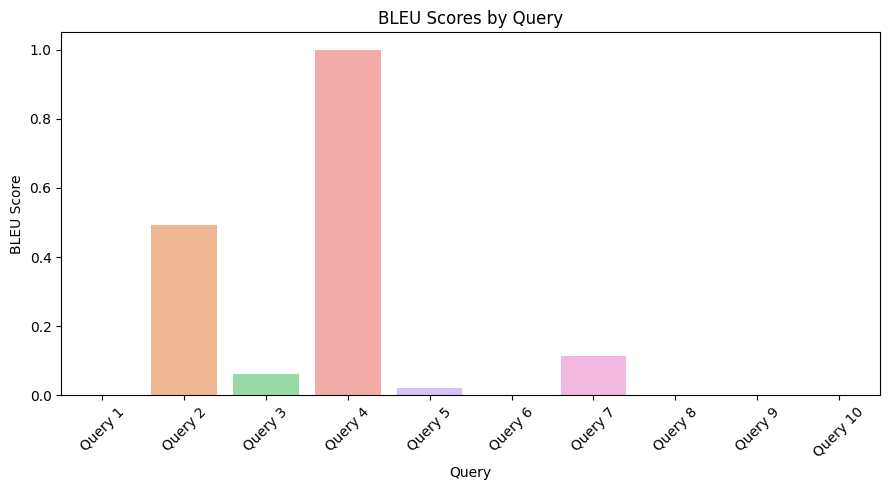

In [ ]:
# Data for plotting blue score
data = {
    'Query': ['Query 1', 'Query 2', 'Query 3', 'Query 4', 'Query 5', 'Query 6', 'Query 7', 'Query 8', 'Query 9', 'Query 10'],
    'BLEU Score': bleu_scores
}

# Create DataFrame
df = pd.DataFrame(data)

plt.figure(figsize=(9, 5))
sns.barplot(x='Query', y='BLEU Score', data=df, palette="pastel")
plt.title('BLEU Scores by Query')
plt.xlabel('Query')
plt.ylabel('BLEU Score')
plt.xticks(rotation=45)
plt.tight_layout()

In [ ]:
meteor_scores

[0.22624434389140272,
 0.8915330493711298,
 0.36691810344827586,
 0.9999984779716842,
 0.23244879962567042,
 0.13677402920864934,
 0.23247711088504583,
 0.24468971261974182,
 0.16326530612244897,
 0.15486725663716816]

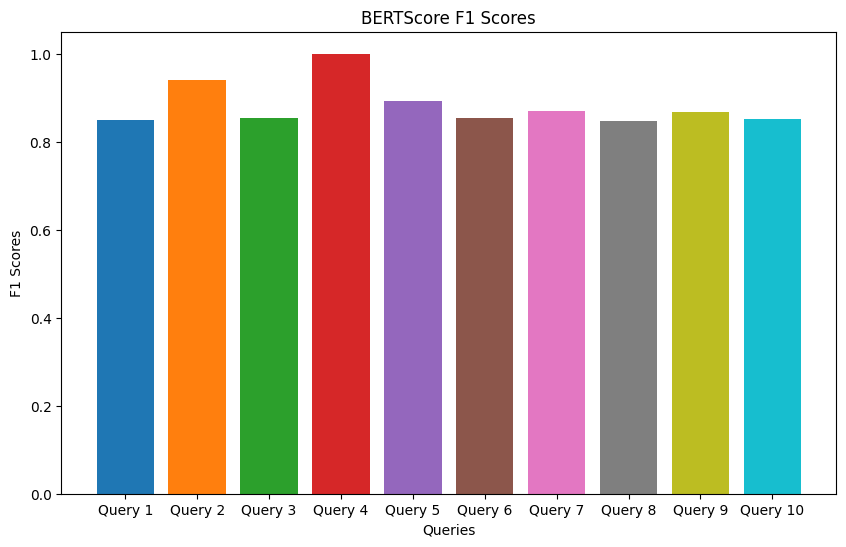

In [ ]:
#BERT Score Results 
queries = ['Query 1', 'Query 2', 'Query 3', 'Query 4', 'Query 5', 'Query 6', 'Query 7', 'Query 8', 'Query 9', 'Query 10']
scores = F1

plt.figure(figsize=(10, 6))
bars = plt.bar(queries, scores, color=plt.get_cmap('tab10').colors)
plt.title('BERTScore F1 Scores')
plt.xlabel('Queries')
plt.ylabel('F1 Scores')
plt.show()


tensor([0.8435, 0.9086, 0.8310, 1.0000, 0.9257, 0.9182, 0.8693, 0.8165, 0.8589,
        0.8292])


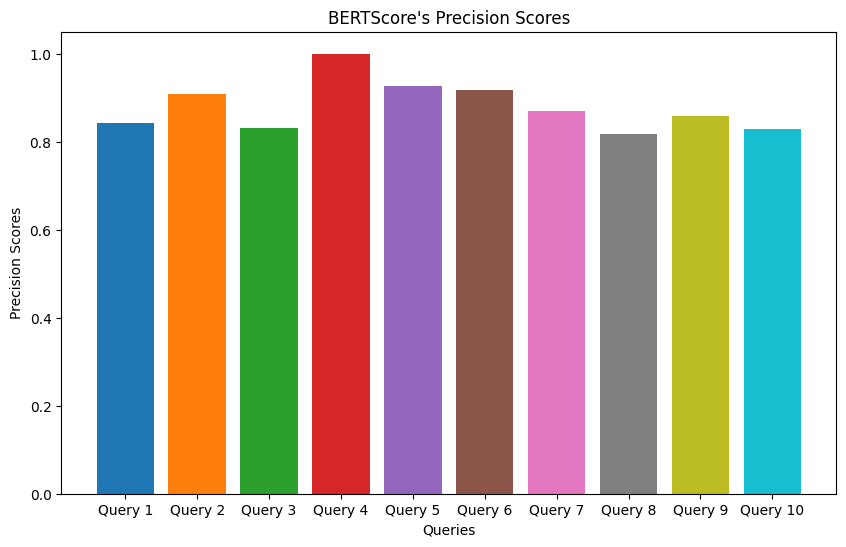

In [ ]:
#BERTScore for Precision
print(P)
queries = ['Query 1', 'Query 2', 'Query 3', 'Query 4', 'Query 5', 'Query 6', 'Query 7', 'Query 8', 'Query 9', 'Query 10']
scores = P

plt.figure(figsize=(10, 6))
bars = plt.bar(queries, scores, color=plt.get_cmap('tab10').colors)
plt.title('''BERTScore's Precision Scores''')
plt.xlabel('Queries')
plt.ylabel('Precision Scores')
plt.show()

tensor([0.8553, 0.9760, 0.8792, 1.0000, 0.8609, 0.8512, 0.8713, 0.8813, 0.8773,
        0.8730])


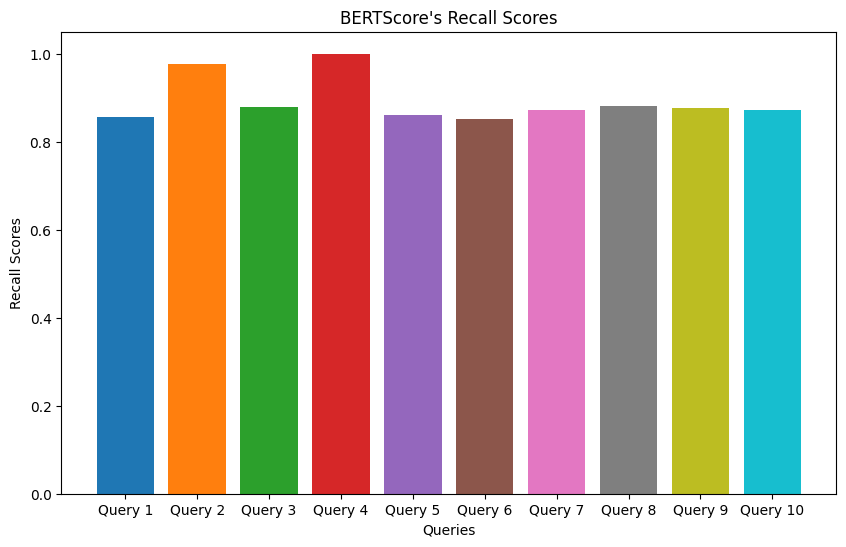

In [ ]:
#BERTScore for Recall
print(R)
queries = ['Query 1', 'Query 2', 'Query 3', 'Query 4', 'Query 5', 'Query 6', 'Query 7', 'Query 8', 'Query 9', 'Query 10']
scores = R

plt.figure(figsize=(10, 6))
bars = plt.bar(queries, scores, color=plt.get_cmap('tab10').colors)
plt.title('''BERTScore's Recall Scores''')
plt.xlabel('Queries')
plt.ylabel('Recall Scores')
plt.show()

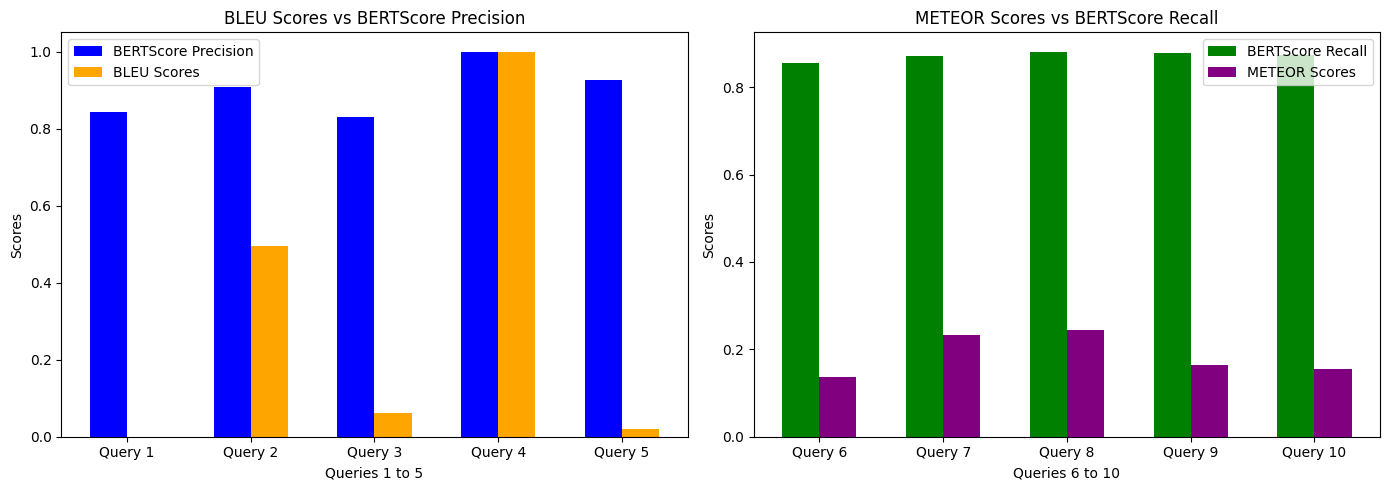

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data: BERT Precision, Recall, BLEU, and METEOR Scores
bert_precision = [0.8435, 0.9086, 0.8310, 1.0000, 0.9257]
bert_recall = [0.8541, 0.8713, 0.8813, 0.8773, 0.8730]
bleu_scores = [4.5853e-155, 0.4942, 0.0621, 1.0000, 0.0213]
meteor_scores = [0.1368, 0.2325, 0.2446, 0.1632, 0.1548]

# Creating a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plotting BLEU Scores to BERTScore Precision for Query 1 to 5
x1 = np.arange(len(bert_precision))  # X axis for Query 1 to Query 5
ax[0].bar(x1 - 0.15, bert_precision, width=0.3, label='BERTScore Precision', color='blue')
ax[0].bar(x1 + 0.15, bleu_scores, width=0.3, label='BLEU Scores', color='orange')
ax[0].set_title('BLEU Scores vs BERTScore Precision')
ax[0].set_xlabel('Queries 1 to 5')
ax[0].set_ylabel('Scores')
ax[0].set_xticks(x1)
ax[0].set_xticklabels([f'Query {i+1}' for i in range(5)])
ax[0].legend()

# Plotting METEOR Scores to BERTScore Recall for Query 6 to 10
x2 = np.arange(len(bert_recall))  # X axis for Query 6 to Query 10
ax[1].bar(x2 - 0.15, bert_recall, width=0.3, label='BERTScore Recall', color='green')
ax[1].bar(x2 + 0.15, meteor_scores, width=0.3, label='METEOR Scores', color='purple')
ax[1].set_title('METEOR Scores vs BERTScore Recall')
ax[1].set_xlabel('Queries 6 to 10')
ax[1].set_ylabel('Scores')
ax[1].set_xticks(x2)
ax[1].set_xticklabels([f'Query {i+6}' for i in range(5)])
ax[1].legend()

plt.tight_layout()
plt.show()


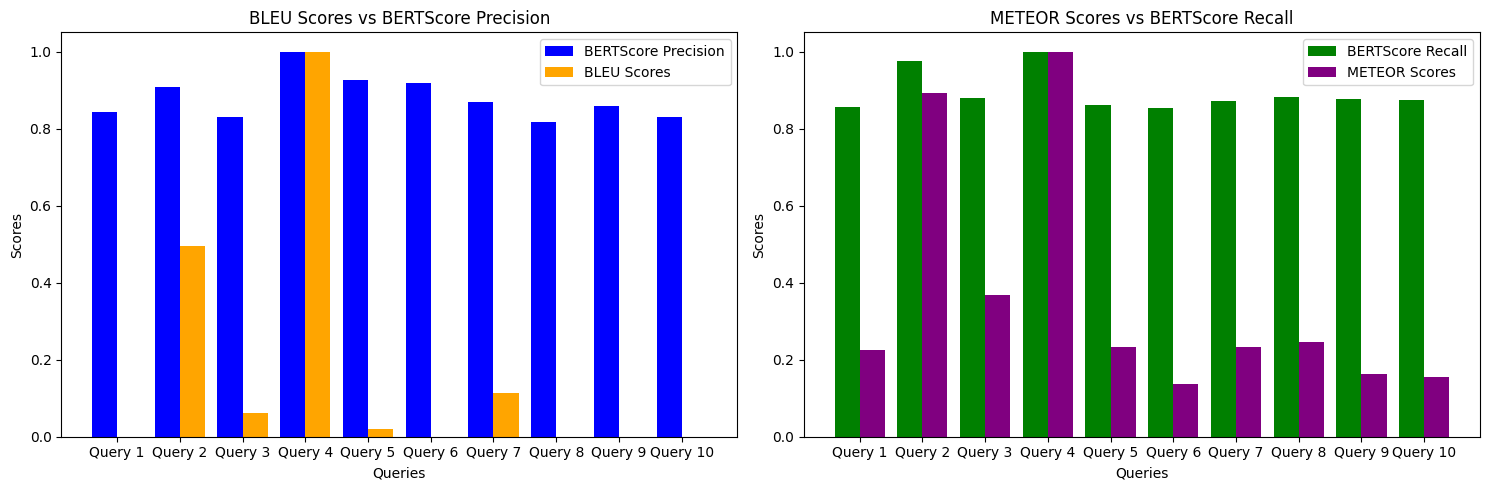

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# # Data: List of Scores
# P = [0.8435, 0.9086, 0.8310, 1.0000, 0.9257, 0.9182, 0.8693, 0.8165, 0.8589, 0.8292]  # BERTScore Precision
# R = [0.8553, 0.9760, 0.8792, 1.0000, 0.8609, 0.8541, 0.8713, 0.8813, 0.8773, 0.8730]  # BERTScore Recall
# bleu_scores = [4.5853e-155, 0.4942, 0.0621, 1.0000, 0.0213, 5.7433e-156, 0.1136, 3.0015e-155, 3.9623e-155, 1.0080e-237]
# meteor_scores = [0.2262, 0.8915, 0.3669, 0.9999, 0.2324, 0.1368, 0.2325, 0.2446, 0.1632, 0.1548]

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot BLEU Scores vs BERTScore Precision for all Queries 1 to 10
x = np.arange(10)  # X-axis for Queries 1 to 10
ax[0].bar(x - 0.2, P, width=0.4, label='BERTScore Precision', color='blue')
ax[0].bar(x + 0.2, bleu_scores, width=0.4, label='BLEU Scores', color='orange')
ax[0].set_title('BLEU Scores vs BERTScore Precision')
ax[0].set_xlabel('Queries')
ax[0].set_ylabel('Scores')
ax[0].set_xticks(x)
ax[0].set_xticklabels([f'Query {i+1}' for i in range(10)])
ax[0].legend()

# Plot METEOR Scores vs BERTScore Recall for all Queries 1 to 10
ax[1].bar(x - 0.2, R, width=0.4, label='BERTScore Recall', color='green')
ax[1].bar(x + 0.2, meteor_scores, width=0.4, label='METEOR Scores', color='purple')
ax[1].set_title('METEOR Scores vs BERTScore Recall')
ax[1].set_xlabel('Queries')
ax[1].set_ylabel('Scores')
ax[1].set_xticks(x)
ax[1].set_xticklabels([f'Query {i+1}' for i in range(10)])
ax[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
query= [
    "how many american presidents have taken the oat",
    "Why should we, as the Israeli people, trust you?",
    "What is the relationship between task force and justice?",
    "What kind of report do special task force provide",
    "What did Horowitz ask about death to America",
    "What did Shruti Revankar asked Obama?"
    "Are there legitimate concerns about the next 15 years? relating to Iran has a history",
    "What did was mentioned about working with allies in news conference",
    "In energy remarks, what did Obama identify as a major challenge in transitioning to clean energy?"
]

Calculation of Mean and Standard Deviation

In [ ]:
import numpy as np

# Assuming F1, bleu_scores, and meteor_scores are either tensors or lists
# Convert to NumPy arrays if needed
F1 = np.array(F1) if not isinstance(F1, np.ndarray) else F1
bleu_scores = np.array(bleu_scores) if not isinstance(bleu_scores, np.ndarray) else bleu_scores
meteor_scores = np.array(meteor_scores) if not isinstance(meteor_scores, np.ndarray) else meteor_scores

# Calculate Mean and Standard Deviation
mean_bert_f1 = np.mean(F1)
std_bert_f1 = np.std(F1)

mean_bleu = np.mean(bleu_scores)
std_bleu = np.std(bleu_scores)

mean_meteor = np.mean(meteor_scores)
std_meteor = np.std(meteor_scores)

print(f"Mean BERTScore F1: {mean_bert_f1:.4f} | Std Dev: {std_bert_f1:.4f}")
print(f"Mean BLEU Score: {mean_bleu:.4f} | Std Dev: {std_bleu:.4f}")
print(f"Mean METEOR Score: {mean_meteor:.4f} | Std Dev: {std_meteor:.4f}")


Mean BERTScore F1: 0.8828 | Std Dev: 0.0475
Mean BLEU Score: 0.1691 | Std Dev: 0.3123
Mean METEOR Score: 0.3721 | Std Dev: 0.2930
